# GBM Disscussion

The data here is taken from the Data Hackathon3.x - https://datahack.analyticsvidhya.com/contest/data-hackathon-3x/

## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,4

## Load Data:
The data has been through following pre-processing:
1. City variable dropped because of too many categories
2. DOB converted to Age | DOB dropped
3. EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Sbmitted was missing else 0 | EMI_Loan_Submitted dropped
4. EmployerName dropped because of too many categories
5. Existing_EMI imputed with 0(median) -111 values were missing
6. Interest_Rate_Missing created which is 1 if Interset_Rate was missing else 0 | Interest_Rate dropped
7. Lead_Creation_Date dropped because made little intuitive impact on outcome
8. Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
9. Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped
10. Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped
11. LoggedIN, Salary_Account removed
12. Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
13. Source- top 2 kept as is and all others combined into different category
14. Numerical and One-Hot-Coding performed


In [2]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [3]:
target = 'Disbursed'
IDcol = 'ID'

In [4]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

### Define a function for modeling and cross-validation
This function will do following:

1. fit the model
2. determine training accuracy
3. determinr training AUC
4. determine testing AUC
5. perform CV is performCV is True
6. plot Feature Importance if printFeatureImportance is True

In [5]:
def modelfit(alg,dtrain,dtest,predictors,performCV=True,printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain['Disbursed'])
    
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg,dtrain[predictors],dtrain['Disbursed'],cv=cv_folds,scoring='roc_auc')
    # Print model report
    print('\nModel Report')
    print("Accuracy : {:4g}".format(metrics.accuracy_score(dtrain['Disbursed'],dtrain_predictions)))
    print("AUC Score (Train): {:4f}".format(metrics.roc_auc_score(dtrain['Disbursed'],dtrain_predprob)))
    
    if performCV:
        print("CV score : Mean - {:7g} | Std - {:7g} | Min - {:7g}| Max - {:7g}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    # Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importance')
        plt.ylabel("Feature Imporatnce Score")

## Baseline Model
Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.


Model Report
Accuracy : 0.985601
AUC Score (Train): 0.862264
CV score : Mean - 0.831887 | Std - 0.00955923 | Min - 0.819544| Max - 0.843842


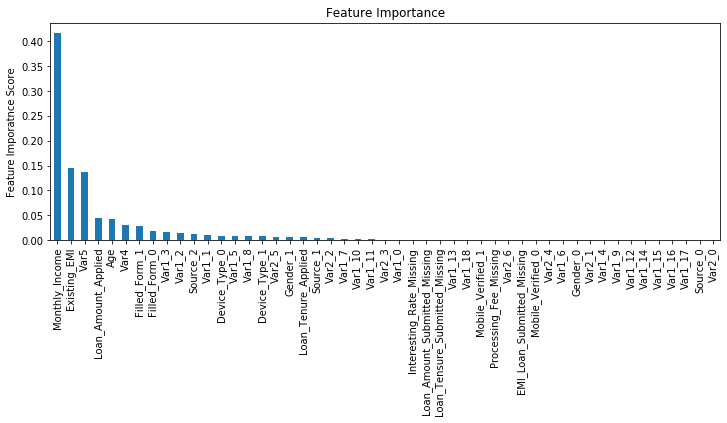

In [6]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0,train,test,predictors)

### GBM Models:
There 2 types of parameter here:
1. Tree-specific parameters
    * min_samples_split
    * min_samples_leaf
    * max_depth
    * min_leaf_nodes
    * max_fatures
    * loss_function
2. Boosting specific parameter
    * n_estimators
    * learning_rate
    * subsample

### Approach for tackling the problem
1. Decide a relatively higher value for learning rate and tune the number of estimators required on that
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computionally ad increase the number of estimators accordingly

## Step 1 - Find the number of estimators for a high learnining rate
We will use the following benchmarks for parameters:

1. min_samples_split = 500 :0.5~1% of total values. Since this is imbalanced class problem, we'll take small value
2. min_samples_leaf = 50: Just using preventing overfitting, will be tuned later.
3. max_depth = 8 : since high number of observations and predictors, choose relativley high value
4. max_features = 'sqrt' : general thumbrule to start with
5. subsample = 0.8 : typically used value(will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators required for this.


In [7]:
# Choose all predictors except target % IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,min_samples_split=500,
                                                            min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                             ,subsample=0.8,random_state=10),param_grid=param_test1,
                        scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch1.fit(train[predictors],train[target])

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [9]:
gsearch1.cv_results_,gsearch1.best_params_,gsearch1.best_score_

({'mean_fit_time': array([1.45720329, 2.14683685, 2.83229389, 3.28247252, 3.89277954,
         4.55995436, 4.78036098]),
  'std_fit_time': array([0.04305021, 0.1394143 , 0.11788249, 0.06092347, 0.04118115,
         0.15046677, 0.48433026]),
  'mean_score_time': array([0.03793912, 0.04448457, 0.04823041, 0.05379868, 0.06068568,
         0.06829209, 0.06358762]),
  'std_score_time': array([0.00436647, 0.00484279, 0.00315378, 0.00194372, 0.00340343,
         0.00293125, 0.0094343 ]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.81147276, 0.81510089, 0.81943895, 0.82212644, 0.82571027,
         0.82688988, 0.82541172]),
  'spl

So we got 70 as the optimal estimators for the 0.1 learning rate.Note that 70 is a reasonable value and can be used as it is. But it might be the same in all cases. Other situations:
1. If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search
2. If the value are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate.

## Step 2 - Tune tree-specific parameters
Now, lets move onto tuninig the tree parameters. We will do this in 2 stages.
1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features

In [13]:
# Grid Search on max_depth and min_samples_leaf
param2_test2 = {'max_depth':range(4,16,2),'min_samples_split':range(100,1101,200)}
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,
                                                             min_samples_leaf=50,max_features='sqrt',subsample=0.8,
                                                             random_state=10),param_grid=param2_test2,
                       scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch2.fit(train[predictors],train[target])

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=70,
                                                  n_iter_no_change=None,
       

In [14]:
gsearch2.cv_results_, gsearch2.best_params_,gsearch2.best_score_

({'mean_fit_time': array([ 2.94791465,  3.22397642,  2.66447248,  2.5266427 ,  2.4835566 ,
          2.44486032,  3.92689686,  3.93228178,  4.03839903,  4.6409862 ,
          5.07458959,  4.34378772,  5.60313487,  5.42922025,  5.39136381,
          7.06559062,  5.87493243,  5.13842216,  6.80866375,  6.51066804,
          6.3264832 ,  6.23699803,  6.12338266,  5.96559052,  7.9153224 ,
          7.46868443,  8.73732395, 11.05820179,  9.49226718,  6.68882666,
          9.05974998, 11.18645148, 11.72913384,  8.25553861,  9.39438901,
          7.44238329]),
  'std_fit_time': array([0.38006699, 0.44676691, 0.05142838, 0.08290082, 0.04664789,
         0.01362642, 0.3729984 , 0.16406649, 0.37295299, 0.33295829,
         0.55482329, 0.37391815, 0.10698949, 0.10540475, 0.05843038,
         1.06766513, 0.57994005, 0.04951017, 0.06624413, 0.14247693,
         0.05934435, 0.10064916, 0.06622746, 0.0822144 , 0.14376873,
         0.16257191, 1.47915171, 0.46167038, 1.11449536, 0.107564  ,
         0.

~~Since we reached the maximum of min_sales_split, we should check higher values as well. Also, we can tune min_samples_leaf with it now as max_depth is fixed. One might argue that max_depth might change for higher value but if you observe the oupput closely, a max_depth of 9 had a better model for most cases. So lets perform a grid search on them:~~

Then, we can tune min_samples_leaf with it now as max_depth and min_samples_leaf are fixed.

In [15]:
# Grid search on min_samples_leaf.
param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,
                                                            max_depth=8,max_features='sqrt',
                                                             min_samples_split=900,subsample=0.8,
                                                            random_state=10),param_grid=param_test3,
                       scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch3.fit(train[predictors],train[target])

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=900,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=70,
                                                  n_iter_no_change=None,
      

In [16]:
gsearch3.cv_results_,gsearch3.best_params_,gsearch3.best_score_

({'mean_fit_time': array([4.29430704, 5.08759437, 5.53360052, 5.87688298, 3.88520818]),
  'std_fit_time': array([0.44888948, 0.14679286, 0.45538905, 0.04589758, 0.28639011]),
  'mean_score_time': array([0.08637166, 0.10153174, 0.08158274, 0.07819009, 0.06184735]),
  'std_score_time': array([0.03359406, 0.03010786, 0.0133566 , 0.01626129, 0.00503863]),
  'param_min_samples_leaf': masked_array(data=[30, 40, 50, 60, 70],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_samples_leaf': 30},
   {'min_samples_leaf': 40},
   {'min_samples_leaf': 50},
   {'min_samples_leaf': 60},
   {'min_samples_leaf': 70}],
  'split0_test_score': array([0.82036971, 0.82264273, 0.82962926, 0.82443355, 0.82052283]),
  'split1_test_score': array([0.83516953, 0.83682595, 0.83840155, 0.83530268, 0.83519341]),
  'split2_test_score': array([0.85112297, 0.85225984, 0.85121067, 0.85141156, 0.84976932]),
  'split3_test_score': array([0.846


Model Report
Accuracy : 0.985371
AUC Score (Train): 0.896853
CV score : Mean - 0.840674 | Std - 0.00868197 | Min - 0.829629| Max - 0.851211


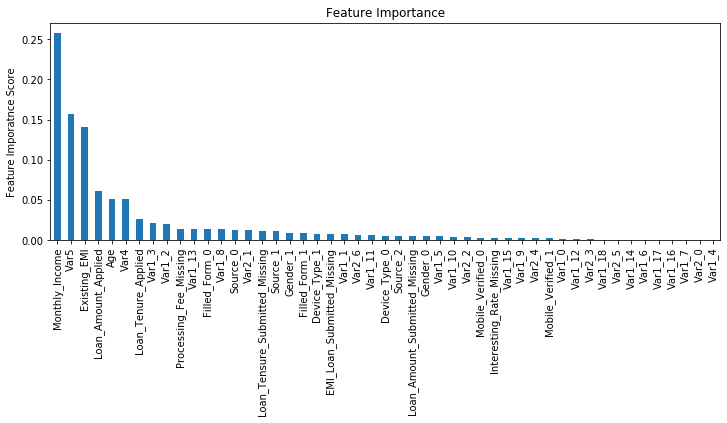

In [17]:
modelfit(gsearch3.best_estimator_,train,test,predictors)

Tune max_features:

In [20]:
# Grid search on max_features
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,
                                                            max_depth=8,min_samples_split=900,
                                                            min_samples_leaf=50,subsample=0.8,
                                                            random_state=10),param_grid=param_test4,
                       scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch4.fit(train[predictors],train[target])

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=900,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=70,
                                                  n_iter_no_change=None,
       

In [21]:
gsearch4.cv_results_,gsearch4.best_params_,gsearch4.best_score_

({'mean_fit_time': array([ 5.3010088 ,  8.23171296,  7.51078405,  9.38572216, 11.50129952,
          9.25539927,  8.96814237]),
  'std_fit_time': array([0.41638678, 0.52100273, 1.02465023, 1.1247082 , 1.61000706,
         0.18074097, 1.02758215]),
  'mean_score_time': array([0.12127633, 0.11365123, 0.07209158, 0.09554849, 0.07422609,
         0.07406535, 0.06191783]),
  'std_score_time': array([0.01563869, 0.03612943, 0.00244702, 0.01744316, 0.00678119,
         0.0055217 , 0.01420551]),
  'param_max_features': masked_array(data=[7, 9, 11, 13, 15, 17, 19],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 7},
   {'max_features': 9},
   {'max_features': 11},
   {'max_features': 13},
   {'max_features': 15},
   {'max_features': 17},
   {'max_features': 19}],
  'split0_test_score': array([0.82962926, 0.82301967, 0.82953548, 0.82333796, 0.82630243,
         0.82372822, 0.8274033 ]),
  '

## Step3 - Tune Subsample and Lower Learning Rate

In [22]:
# Grid search on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,
                                                             max_depth=8,min_samples_split=900,
                                                            min_samples_leaf=50,random_state=10
                                                             ,max_features=7),
                       param_grid=param_test5,scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch5.fit(train[predictors],train[target])

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features=7,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=900,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=70,
                                                  n_iter_no_change=None,
          

In [23]:
gsearch5.cv_results_,gsearch5.best_params_,gsearch5.best_score_

({'mean_fit_time': array([3.53213859, 4.61216936, 6.62588167, 5.45887022, 5.99317913,
         5.43292379]),
  'std_fit_time': array([0.02593233, 0.99652097, 0.48331237, 0.79620453, 0.32227899,
         1.26386021]),
  'mean_score_time': array([0.06961365, 0.07420092, 0.07940564, 0.07864695, 0.09019227,
         0.06768451]),
  'std_score_time': array([0.00842462, 0.00396979, 0.00736056, 0.00245976, 0.02500596,
         0.0123026 ]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([0.82141044, 0.81738401, 0.8231938 , 0.82962926, 0.82796194,
         0.82448704]),
  'split1_test_score': array([0.83466289, 0.83430454, 0.83286196, 0.83840155, 0.83307454,
         0.832484

With all Ttuned lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results:
1/2th learning rate


Model Report
Accuracy : 0.985371
AUC Score (Train): 0.897095
CV score : Mean - 0.838883 | Std - 0.0123376 | Min - 0.819801| Max - 0.852966


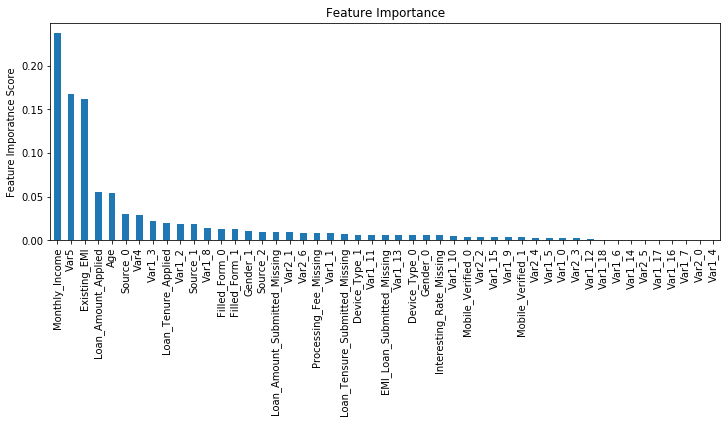

In [28]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm_tuned1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, max_depth=8,
                                        min_samples_split=900,min_samples_leaf=50,subsample=0.8,
                                        random_state=10, max_features=7,warm_start=True)
modelfit(gbm_tuned1,train,test,predictors)
                                        

1/10th learning rate


Model Report
Accuracy : 0.985371
AUC Score (Train): 0.897318
CV score : Mean - 0.840997 | Std - 0.00974342 | Min - 0.826648| Max - 0.852816


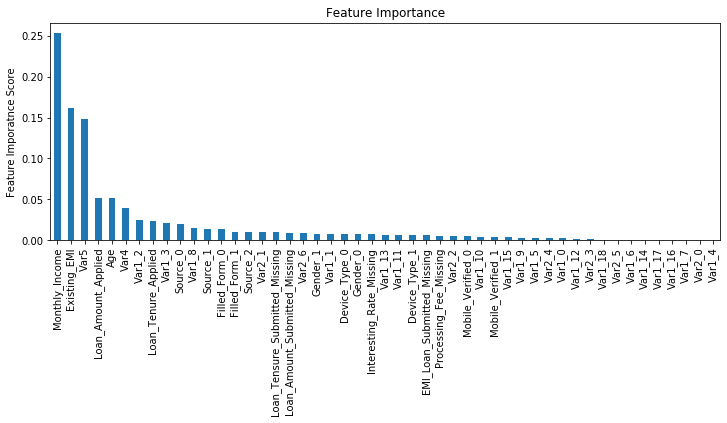

In [29]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm_tuned2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600, max_depth=8,
                                        min_samples_split=900,min_samples_leaf=50,subsample=0.8,
                                        random_state=10, max_features=7,warm_start=True)
modelfit(gbm_tuned2,train,test,predictors)

1/50th learning rate


Model Report
Accuracy : 0.985371
AUC Score (Train): 0.897041
CV score : Mean - 0.841162 | Std - 0.0102488 | Min - 0.82652| Max - 0.853542


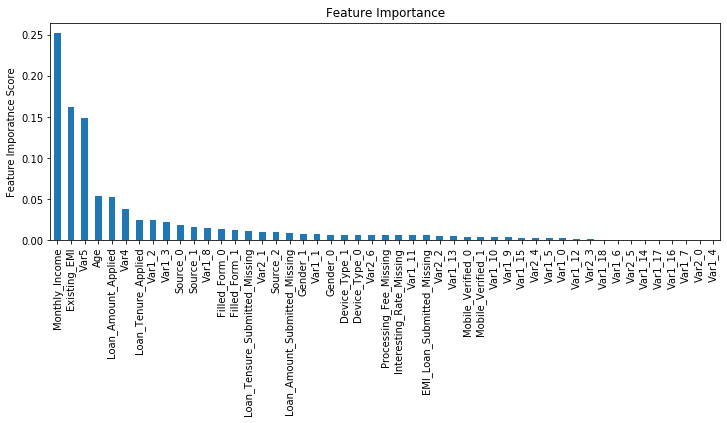

In [30]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm_tuned3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200, max_depth=8,
                                        min_samples_split=900,min_samples_leaf=50,subsample=0.8,
                                        random_state=10, max_features=7,warm_start=True)
modelfit(gbm_tuned3,train,test,predictors)


Model Report
Accuracy : 0.985371
AUC Score (Train): 0.902494
CV score : Mean - 0.841367 | Std - 0.0104064 | Min - 0.826667| Max - 0.854678


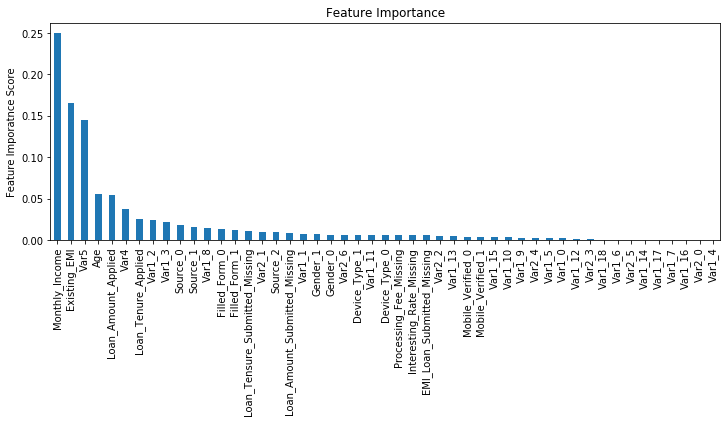

In [31]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm_tuned4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500, max_depth=8,
                                        min_samples_split=900,min_samples_leaf=50,subsample=0.8,
                                        random_state=10, max_features=7,warm_start=True)
modelfit(gbm_tuned4,train,test,predictors)